### Exploring ribosome profiling datasets available on NCBI SRA

This notebook explores ribosome profiling datasets available on NCBI SRA. We aim to group the datasets by kingdom for further analysis using [RIBOSS](https://github.com/lcscs12345/riboss).

1. We will start by searching "ribosome profiling", "ribo-seq", and "riboseq" on NCBI SRA. We will send the search results to Run Selector.

<img src="../screenshots/Screenshot-ncbi.png" />

2. We will download the Metadata, in which our browser will automatically save it as SraRunTable.txt (or .csv). We will rename it by _\[keyword\] and move it to doc.

<img src="../screenshots/Screenshot-runselector.png" />

3. The other important file we need to download is sra_result.csv. We will need to select the Format as Summary and click Create File. We will then rename the files and move them to doc.

<img src="../screenshots/Screenshot-sra_result.png" />

4. The reason of downloading sra_result.csv files is because the we want to get Study Title. Study Title is not available in SraRunTable, which is counterintuitive.

5. Let's import some useful libraries for this analysis

In [1]:
import pandas as pd
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt

We will create a for loop to load the metadata csv files using pandas and append them into a list.

We will concatenate the list as a single pandas dataframe. There are duplicates obtained from the keyword search, which can be removed using drop_duplicates.

In [2]:
dfs = []
for i in glob('../doc/sra_result_*.csv'):
    df = pd.read_csv(i)
    dfs.append(df)
    
sra_result = pd.concat(dfs)
sra_result = sra_result.drop_duplicates()

Here is the header 

sra_result.columns

In [4]:
dfs = []
for i in glob('SraRunTable_*.txt'):
    df = pd.read_csv(i)
    dfs.append(df)
    
SraRunTable = pd.concat(dfs)
SraRunTable = SraRunTable.drop_duplicates('Experiment')

/Volumes/scratch/gardnerlab/cslim/tmp/ipykernel_32478/2839160295.py:3: DtypeWarning: Columns (39,91,95,98,101,111,120,125,127,130,134,135,136,139,141,143,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(i)
/Volumes/scratch/gardnerlab/cslim/tmp/ipykernel_32478/2839160295.py:3: DtypeWarning: Columns (55,56,64,65,67,68,69,70,71,76,77,79,84,86,87,88,89,93,94,95,99,100,105,108,110,111,112,113,114,115,117,118,119,120,121,122,123,124,125,127,128,129,130,131,132,133,134,135,136,137,138,139,140,142,143,144,145) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(i)


In [5]:
df = pd.merge(sra_result, 
              SraRunTable.rename(columns={'Experiment':'Experiment Accession'}), 
              on='Experiment Accession')

Although we queried using specific keywords, we still get results that are not relevant.

In [6]:
df.value_counts('Assay Type')

Assay Type
RNA-Seq             9075
OTHER               8850
ncRNA-Seq            376
RIP-Seq              212
miRNA-Seq            130
ATAC-seq              42
MNase-Seq             20
ChIP-Seq               4
Bisulfite-Seq          2
Targeted-Capture       2
WGS                    1
Name: count, dtype: int64

We will create a subset of OTHER, which may likely to be ribosome profiling

In [7]:
df = df[df['Assay Type']=='OTHER'].copy()

In [8]:
df.value_counts('Organism Name')

Organism Name
Homo sapiens                            2908
Mus musculus                            2073
Saccharomyces cerevisiae                 960
Zea mays                                 401
Arabidopsis thaliana                     242
                                        ... 
Komagataella phaffii                       2
Escherichia coli O157:H7 str. EDL933       2
Moneuplotes crassus                        1
Bubalus bubalis                            1
Anolis carolinensis                        1
Name: count, Length: 108, dtype: int64

We can use a string split function to obtain genus from Organism Name.

In [9]:
df['Genus'] = df['Organism Name'].str.split().apply(lambda x: x[0])
df.value_counts('Genus')

Genus
Homo             2908
Mus              2073
Saccharomyces    1099
Escherichia       432
Zea               401
                 ... 
Komagataella        2
Caulobacter         2
Moneuplotes         1
Bubalus             1
Anolis              1
Name: count, Length: 70, dtype: int64

In [10]:
df['Species'] = df['Organism Name'].str.split()\
.apply(lambda x: x[0] + ' ' + x[1] if len(x)>1 else x[0])

It is possible that the ribosome profiling keyword can be found in any columns. We will fill up NaN with "X" before concatenating the columns as single rows, and create a copy of the dataframe.

In [11]:
df_ = df.fillna('X').copy()

This shows that there are 5177 experiments have "ribo" as a keyword in Experiment Title, Library Name or Sample Name.

In [12]:
df_[df_['Experiment Title'].str.contains('[Rr][Ii][Bb][Oo]') | \
  df_['Library Name_x'].str.contains('[Rr][Ii][Bb][Oo]') | \
  df_['Sample Name'].str.contains('[Rr][Ii][Bb][Oo]')].shape

(5177, 252)

To check if the SRA experiments are ribosome profiling, we need to find the ribosome profiling keyword in every single column. We will join all columns as strings using list comprehension. List comprehension allows us to create a new list based on an existing list with slight modifications. We can leverage list comprehension and join to create long, concatenated strings.

In [13]:
df_['cat'] = df_.values.tolist()
df_['cat_str'] = df_['cat'].apply(lambda x: '_'.join([str(i) for i in x]))

In [14]:
df_['cat_str'][0]

'SRX19973679_GSM7177581: AIM29 KO, Ribo-seq; Saccharomyces cerevisiae W303; OTHER_Saccharomyces cerevisiae W303_NextSeq 2000_Vladimir Denic, Molecular and Cellular Biology, Ha_SRP432738_Ribosome profiling of Aim29-knockout S.cerevisiae cells_SRS17320316_X_1162.08_1_28267859_3476946657_GSM7177581_OTHER_TRANSCRIPTOMIC_other_SRR24175965_OTHER_123.0_3476946657.0_PRJNA955811_SAMN34192137_1218531115.0_VLADIMIR DENIC, MOLECULAR AND CELLULAR BIOLOGY, HARVARD UNIVERSITY_public_fastq,sra_gs,ncbi,s3_gs.US,ncbi.public,s3.us-east-1_NextSeq 2000_SINGLE_other_TRANSCRIPTOMIC_Saccharomyces cerevisiae W303_ILLUMINA_2023-04-18T00:00:00Z_2023-04-14T17:32:00Z_1.0_GSM7177581_SRP432738_yeast cell_X_GSM7177581_X_W303_yeast cell_X_X_X_AIM29 KO_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X_X

We will then use regular expression to find "ribo" and do a couple of list comprehension to determine the presence of the keyword and the counts

In [15]:
import re

df_['cat_findall'] = df_['cat'].apply(lambda x: [re.findall(r'[Rr][Ii][Bb][Oo]', \
                                                            str(i)) for i in x])

In [16]:
df_['cat_findall'] = df_['cat_findall'].apply(lambda x: [len(i) for i in x])

In [17]:
df_['cat_findall'] = df_['cat_findall'].apply(lambda x: [k for k, v in enumerate(x) if v > 0])

In [18]:
df_['cat_findall']

0                [1, 6]
1                [1, 6]
2        [1, 6, 13, 42]
3        [1, 6, 13, 42]
4        [1, 6, 13, 42]
              ...      
18709                []
18710                []
18711                []
18712                []
18713                []
Name: cat_findall, Length: 8850, dtype: object

In [19]:
cat_findall = [j for i in df_['cat_findall'] for j in i]

In [20]:
cat_findall = list(set(cat_findall))

In [21]:
ribo_counts = []
for i in cat_findall:
    ribo_count = df_[df_[df_.columns[i]].str.contains('[Rr][Ii][Bb][Oo]')]\
    .value_counts(df_.columns[i])
    ribo_counts.append(ribo_count)

We can get any experiments of interest by subsetting.

In [28]:
df_[df_['Experiment Title'].str.contains('V7 leaf')]

,Experiment Accession,Experiment Title,Organism Name,Instrument_x,Submitter,Study Accession,Study Title,Sample Accession,Sample Title,"Total Size, Mb",...,rrna_depletion,infection,Method,subcellular_compartment,plasmid,Genus,Species,cat,cat_str,cat_findall
4185,SRX8488526,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6788100,X,413.11,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488526, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488526_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
4186,SRX8488525,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6788101,X,368.40,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488525, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488525_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
4187,SRX8488524,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6788099,X,392.95,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488524, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488524_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
4188,SRX8488523,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6788098,X,229.46,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488523, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488523_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
4189,SRX8488522,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6788097,X,325.59,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488522, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488522_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,SRX8488228,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6787803,X,287.35,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488228, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488228_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
4484,SRX8488227,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6787802,X,650.99,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488227, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488227_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
4485,SRX8488226,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6787801,X,683.21,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488226, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488226_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"
4486,SRX8488225,3'Ribo-seq of maize: V7 leaf,Zea mays,HiSeq X Ten,Huazhong Agricultural University,SRP266320,A new cost-effective ribosome profiling technique,SRS6787800,X,443.81,...,X,X,X,X,X,Zea,Zea mays,"[SRX8488225, 3'Ribo-seq of maize: V7 leaf, Zea...",SRX8488225_3'Ribo-seq of maize: V7 leaf_Zea ma...,"[1, 6, 146]"


We can also filter the library size by Total Bases or Total Size in Mb.

In [29]:
df_[(df_['Total Bases']<10) & (df_['Total Size, Mb']>1000)]

,Experiment Accession,Experiment Title,Organism Name,Instrument_x,Submitter,Study Accession,Study Title,Sample Accession,Sample Title,"Total Size, Mb",...,rrna_depletion,infection,Method,subcellular_compartment,plasmid,Genus,Species,cat,cat_str,cat_findall
5000,ERX3957564,Illumina HiSeq 2500 sequencing,Streptomyces avermitilis MA-4680 = NBRC 14893,Illumina HiSeq 2500,KAIST,ERP120150,Trimmed read fastq files and mapped read bam f...,ERS4349686,X,5252.71,...,X,X,X,X,X,Streptomyces,Streptomyces avermitilis,"[ERX3957564, Illumina HiSeq 2500 sequencing, S...",ERX3957564_Illumina HiSeq 2500 sequencing_Stre...,"[6, 60, 61]"
5001,ERX3957563,Illumina HiSeq 2500 sequencing,Streptomyces avermitilis MA-4680 = NBRC 14893,Illumina HiSeq 2500,KAIST,ERP120150,Trimmed read fastq files and mapped read bam f...,ERS4349686,X,7119.50,...,X,X,X,X,X,Streptomyces,Streptomyces avermitilis,"[ERX3957563, Illumina HiSeq 2500 sequencing, S...",ERX3957563_Illumina HiSeq 2500 sequencing_Stre...,"[6, 60, 61]"
5014,ERX3957542,Illumina HiSeq 2500 sequencing,Streptomyces avermitilis MA-4680 = NBRC 14893,Illumina HiSeq 2500,KAIST,ERP120150,Trimmed read fastq files and mapped read bam f...,ERS4349683,X,4218.23,...,X,X,X,X,X,Streptomyces,Streptomyces avermitilis,"[ERX3957542, Illumina HiSeq 2500 sequencing, S...",ERX3957542_Illumina HiSeq 2500 sequencing_Stre...,"[6, 13, 42, 60, 61]"
5017,ERX3957539,Illumina HiSeq 2500 sequencing,Streptomyces avermitilis MA-4680 = NBRC 14893,Illumina HiSeq 2500,KAIST,ERP120150,Trimmed read fastq files and mapped read bam f...,ERS4349683,X,4134.72,...,X,X,X,X,X,Streptomyces,Streptomyces avermitilis,"[ERX3957539, Illumina HiSeq 2500 sequencing, S...",ERX3957539_Illumina HiSeq 2500 sequencing_Stre...,"[6, 13, 42, 60, 61]"


We expect that Total Bases strongly correlate with Total Size. We can also mark the first quartile (Q1) of the dataset, which is about 0.5 GB.

In [31]:
df_.describe()

,"Total Size, Mb",Total RUNs,Total Spots,Total Bases
count,8850.000000,8850.000000,8.850000e+03,8.850000e+03
mean,1549.013992,1.237288,5.456143e+07,3.559568e+09
std,2682.845154,1.146402,5.965477e+07,7.378940e+09
min,0.000000,1.000000,0.000000e+00,0.000000e+00
25%,461.295000,1.000000,1.891277e+07,1.016397e+09
50%,943.030000,1.000000,3.757532e+07,2.079079e+09
75%,1877.562500,1.000000,6.848509e+07,4.211758e+09
max,99215.560000,16.000000,9.918211e+08,2.975463e+11


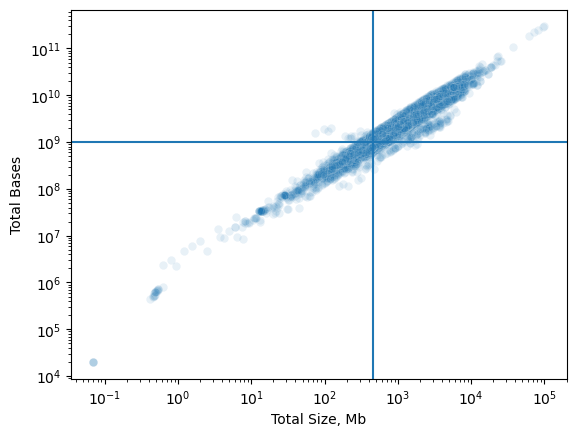

In [30]:
ax = sns.scatterplot(data = df_, x='Total Size, Mb', y='Total Bases', alpha=0.1)
plt.axvline(x=461.295)
plt.axhline(y=1.016397e+09)
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

We can also get descriptive statistics of the SRA experiments

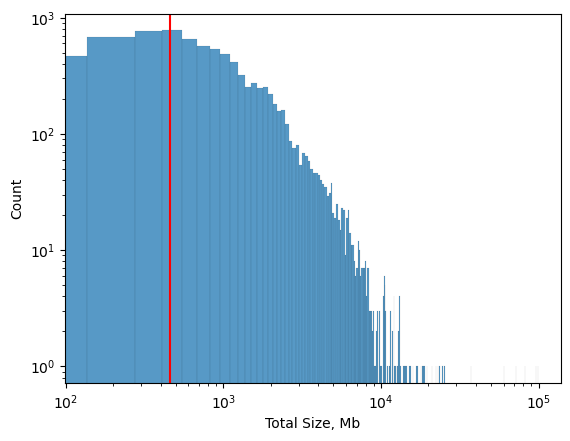

In [32]:
ax = sns.histplot(df_['Total Size, Mb'])
ax.set_xscale("log")
ax.set_yscale("log")
plt.axvline(x = 461.295000, color = 'r')
plt.show()

Let's say we are interested in data larger than the Q1 of Total Size, we can count the number of experiments by species.

In [33]:
df_[df_['Total Size, Mb']>461.295000].value_counts('Organism Name')

Organism Name
Homo sapiens                   2293
Mus musculus                   1626
Saccharomyces cerevisiae        738
Arabidopsis thaliana            193
Rattus norvegicus               172
                               ... 
Solanum pennellii                 1
Kluyveromyces marxianus           1
Bubalus bubalis                   1
Pseudomonas aeruginosa PA14       1
Anolis carolinensis               1
Length: 100, dtype: int64

To group the SRA experiments by kingdom, we will first create text file using Organism Name below.

In [34]:
'\n'.join(df_[df_['Total Size, Mb']>461.295]['Organism Name'].unique().tolist())

'Saccharomyces cerevisiae W303\nMus musculus\nHomo sapiens\nSaccharomyces cerevisiae\nArabidopsis thaliana\nStreptococcus pneumoniae D39\nDrosophila melanogaster\nChlorocebus sabaeus\nBos taurus\nEscherichia coli\nLacticaseibacillus rhamnosus GG\nCricetulus griseus\nEscherichia coli str. K-12 substr. W3110\nSorghum bicolor\nNeurospora crassa\nEscherichia coli str. K-12 substr. MG1655\nDanio rerio\nEscherichia coli K-12\nSynechocystis sp. PCC 6803\nOryza sativa Japonica Group\nArabidopsis\nZea mays\nXenopus laevis\nStreptomyces clavuligerus\nRattus norvegicus\nCulex tarsalis\nKomagataella phaffii\nCandida albicans\nMycobacterium tuberculosis H37Rv\nChlorocebus aethiops aethiops\nsynthetic construct\nStreptomyces tsukubensis NRRL18488\nStreptomyces venezuelae\nStreptomyces avermitilis MA-4680 = NBRC 14893\nSolanum lycopersicum\nCaenorhabditis elegans\nHaloferax volcanii DS2\nStreptomyces griseus\nGallus gallus\nSchizosaccharomyces pombe\nSaccharomyces cerevisiae BY4741\nSolanum pennellii

We will then run efetch and xtract

```
while read i <&3; do \
    paste <(esearch -db taxonomy -query "${i}" \
    | efetch -format native -mode xml \
    | xtract -pattern TaxaSet \
      -group LineageEx \
      -block Taxon \
      -if Rank -equals "kingdom" \
      -subset Taxon -tab '\n' -def NA \
      -element TaxId,Rank,ScientificName) \
     <(echo ${i})
done 3< ../doc/orgname.txt > ../doc/orgkingdom.txt
```

We can also run shell commands within a cell

In [21]:
! head ../doc/orgkingdom.txt

2759	superkingdom	Eukaryota	Saccharomyces cerevisiae W303
4751	kingdom	Fungi	
451864	subkingdom	Dikarya	
2759	superkingdom	Eukaryota	Mus musculus
33208	kingdom	Metazoa	
2759	superkingdom	Eukaryota	Homo sapiens
33208	kingdom	Metazoa	
2759	superkingdom	Eukaryota	Saccharomyces cerevisiae
4751	kingdom	Fungi	
451864	subkingdom	Dikarya	


Let's import the efetch/xtract result.

In [22]:
orgkingdom = pd.read_csv('orgkingdom.txt', sep='\t', header=None)
orgkingdom.columns = ['taxid','hierarchy','taxa','Organism Name']
orgkingdom.fillna(method='ffill', inplace=True)
orgkingdom = orgkingdom[orgkingdom.hierarchy=='kingdom']

This gives us an idea of the ribosome profiling experiments performed across kingdom.

In [23]:
orgkingdom.value_counts('taxa')

taxa
Metazoa          24
Viridiplantae    15
Fungi            13
Orthornavirae     5
Bamfordvirae      1
Name: count, dtype: int64

In [24]:
orgkingdom[orgkingdom['taxa']=='Bamfordvirae']

,taxid,hierarchy,taxa,Organism Name
162,2732005.0,kingdom,Bamfordvirae,Vaccinia virus WR


We can check the shape (rows, columns) of the dataframes

In [25]:
df.shape, df_.shape

((8850, 252), (8850, 255))

Let's merge taxa with SRA experiments

In [26]:
df_kingdom = pd.merge(orgkingdom, df_)

In [27]:
df_kingdom.value_counts('taxa')

taxa
Metazoa          5886
Fungi            1259
Viridiplantae     844
Orthornavirae      83
Bamfordvirae       12
Name: count, dtype: int64

There are 617 Study Accessions

In [29]:
df_kingdom['Study Accession'].unique().shape

(617,)

If we are interested in plants, we can subset the dataframe and count the SRA experiments by species

In [41]:
df_kingdom[df_kingdom.taxa=='Viridiplantae'].value_counts('Organism Name')

Organism Name
Zea mays                                                  401
Arabidopsis thaliana                                      242
Solanum lycopersicum                                       43
Oryza sativa Japonica Group                                35
Oryza sativa                                               27
Solanum pennellii                                          17
Chlamydomonas reinhardtii                                  16
Arabidopsis                                                14
Triticum aestivum                                          12
Nicotiana benthamiana                                       9
Acer truncatum                                              6
Oenothera elata subsp. hookeri                              6
Oenothera elata subsp. hookeri x Oenothera grandiflora      6
Sorghum bicolor                                             6
Brassica napus                                              4
dtype: int64

In [42]:
df_kingdom[df_kingdom['taxa']=='Bamfordvirae']['Experiment Title']

8047    Ribo-seq, 4 h  post VACV infection, Lactimidom...
8048    Ribo-seq, 2 h  post VACV infection, Lactimidom...
8049    Ribo-seq, 8 h  post VACV infection, Harrington...
8050    Ribo-seq, 4 h  post VACV infection, Harrington...
8051    Ribo-seq, 2 h  post VACV infection, Harrington...
8052    Ribo-seq, 8 h  post VACV infection, cyclohexim...
8053    Ribo-seq, 4 h  post VACV infection, cyclohexim...
8054    Ribo-seq, 2 h  post VACV infection, cyclohexim...
8055                    Ribo-seq, 8 h post VACV infection
8056                    Ribo-seq, 4 h post VACV infection
8057                     Ribo-seq, 2h post VACV infection
8058    Ribo-seq, 8h post VACV infection, Lactimidomyc...
Name: Experiment Title, dtype: object